### Introduction

Welcome to this notebook, which focuses on the comparison of several machine learning models for predicting the **compressive strength of concrete** based on various features such as the age of the concrete, and the amounts of materials like cement, water, and aggregates.

In a previous, detailed script, I conducted an **Exploratory Data Analysis (EDA)** to gain insights into the dataset and performed **feature engineering** to prepare the data for modeling. The script also provided a comprehensive explanation and testing of several predictive models, including linear regression, decision trees, random forests, gradient boosting machines (GBM), and support vector machines (SVM).

The goal of this notebook is to **compare the performance of machine learning models** to identify the most suitable model for predicting concrete compressive strength. This includes training each model, fine-tuning hyperparameters, and evaluating their performance using metrics such as R² and RMSE. Finally, I will compare the feature importances of the top models to better understand which features contribute most to accurate predictions.

By the end of this notebook, you will have a clear overview of how these models perform and which model can best predict the compressive strength of concrete based on the available data.

### Data Loading, Cleaning and Transforming

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = 'concrete_data.csv'  # file path
concrete_data = pd.read_csv(file_path)
df=concrete_data

print(f"Data shape: {concrete_data.shape}")

# Check for exact duplicates
duplicate_rows = concrete_data[concrete_data.duplicated()]
# Remove exact duplicates
concrete_data = concrete_data.drop_duplicates()
print(f"Data shape after removing duplicates: {concrete_data.shape}")

# Check for missing values
missing_values = concrete_data.isnull().sum()
missing_percent = (missing_values / concrete_data.shape[0]) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data

# Displaying missing values, if any
if missing_values.any():
    missing_values_df = pd.DataFrame(missing_values, columns=['Missing Values'])
    display(HTML("<h3>Missing Values</h3>"))
    display(missing_values_df)
else:
    print("No missing values found in the dataset.")


# Logarithmic transformation of the Age Feature

concrete_data['Log_Age'] = np.log(concrete_data['Age'])


Data shape: (1030, 9)
Data shape after removing duplicates: (1005, 9)
No missing values found in the dataset.


### Machine Learning

#### Split Train, Dev and Test Data

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Load your data
# Assuming concrete_data is already loaded as a DataFrame

# Define the columns to include
columns = [
    'Cement', 'Water', 'Log_Age', 'Blast Furnace Slag', 'Fly Ash',
    'Superplasticizer', 'Coarse Aggregate', 
    'Fine Aggregate', 'Strength'
]

# Create a new DataFrame with only the specified columns
data = concrete_data[columns]

X = data.drop(['Strength'], axis=1)
y = data['Strength']


# Step 1: First, split the data into 85% (train + dev) and 15% (test)
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.15, random_state=31)

# Step 2: Then, split the remaining 85% (train + dev) into train (70%) and dev (30%)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.3, random_state=31)

# Now, X_train, y_train: 70% of the original data
# X_dev, y_dev: 15% of the original data (dev set)
# X_test, y_test: 15% of the original data (test set)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

# Train your models on the train data, validate on the dev set, and finally evaluate on the test set.


#### Set parameter grids and build models

In [11]:
# Hyperparameter grids for each model
param_grids = {
    'ElasticNet': {
        'alpha': [0.05, 0.1, 0.15],
        'l1_ratio': [0.5, 0.7, 0.9]
    },
    'Decision Tree': {
        'max_depth': [4, 5, 6],  # Reducing max_depth to control overfitting
        'min_samples_split': [10, 15],
        'min_samples_leaf': [10, 15]  # Increasing min_samples_leaf for smoother trees
    },
    'Random Forest': {
        'n_estimators': [100, 150],
        'max_depth': [10, 15, None],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [5, 10]  # Increasing min_samples_leaf to prevent overfitting
    },
    'Gradient Boosting': {
        'n_estimators': [250, 300],  # Slightly reducing the number of trees
        'learning_rate': [0.01, 0.05],
        'max_depth': [4, 5],  # Smaller depth for more generalization
        'min_samples_split': [10, 15],
        'min_samples_leaf': [10, 15]
    },
    'SVM': {
        'C': [5, 10],
        'epsilon': [0.2, 0.5],
        'kernel': ['rbf']
    },
    'k-NN': {
        'n_neighbors': [10, 15, 20],  # Testing more neighbors for smoother predictions
        'weights': ['distance', 'uniform']  # Testing both weights for better generalization
    },
    'Artificial Neural Network (ANN)': {
        'hidden_layer_sizes': [(50, 50), (100, 50)],  # Smaller layers to prevent overfitting
        'alpha': [0.001, 0.01],  # Increased regularization
        'learning_rate_init': [0.001, 0.005]
    }
}

# Define models for the GridSearch
models = {
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVM': SVR(),
    'k-NN': KNeighborsRegressor(),
    'Artificial Neural Network (ANN)': MLPRegressor(random_state=42, max_iter=1000)
}

results = []
feature_importances = {}

# Assuming you have already split data into X_train, X_dev, X_test, y_train, y_dev, y_test

# Train and evaluate each model with GridSearchCV
for name, model in models.items():
    param_grid = param_grids[name]
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters for {name}: {grid_search.best_params_}")

    # Predictions for Train, Dev, and Test sets
    y_train_pred = best_model.predict(X_train)
    y_dev_pred = best_model.predict(X_dev)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate R² and RMSE for training, dev, and test sets
    train_r2 = r2_score(y_train, y_train_pred)
    dev_r2 = r2_score(y_dev, y_dev_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    dev_rmse = np.sqrt(mean_squared_error(y_dev, y_dev_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Calculate the difference between train, dev, and test metrics
    r2_diff_dev = train_r2 - dev_r2
    r2_diff_test = train_r2 - test_r2
    
    rmse_diff_dev = dev_rmse - train_rmse
    rmse_diff_test = test_rmse - train_rmse
    
    # Store results
    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Dev R²': dev_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Dev RMSE': dev_rmse,
        'Test RMSE': test_rmse,
        'Dev R² Difference': r2_diff_dev,
        'Test R² Difference': r2_diff_test,
        'Dev RMSE Difference': rmse_diff_dev,
        'Test RMSE Difference': rmse_diff_test
    })

# Convert results into a DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Round the results DataFrame to 3 decimal places
results_df = results_df.round(3)

# Display the results
print(results_df)


Best hyperparameters for ElasticNet: {'alpha': 0.05, 'l1_ratio': 0.9}
Best hyperparameters for Decision Tree: {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best hyperparameters for Random Forest: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 150}
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 300}
Best hyperparameters for SVM: {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}
Best hyperparameters for k-NN: {'n_neighbors': 10, 'weights': 'distance'}
Best hyperparameters for Artificial Neural Network (ANN): {'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.005}
                             Model  Train R²  Dev R²  Test R²  Train RMSE  \
0                       ElasticNet     0.813   0.792    0.808       6.897   
1                    Decision Tree     0.837   0.766    0.790       6.429   
2                    Random Fo

In [4]:
print(results_df)

                             Model  Train R²  Dev R²  Test R²  Train RMSE  \
0                       ElasticNet     0.814   0.804    0.796       6.894   
1                    Decision Tree     0.819   0.729    0.738       6.796   
2                    Random Forest     0.929   0.860    0.828       4.241   
3                Gradient Boosting     0.986   0.915    0.888       1.892   
4                              SVM     0.919   0.875    0.866       4.546   
5                             k-NN     0.999   0.822    0.792       0.410   
6  Artificial Neural Network (ANN)     0.976   0.912    0.910       2.484   

   Dev RMSE  Test RMSE  Dev R² Difference  Test R² Difference  \
0     7.268      7.757              0.010               0.017   
1     8.539      8.794              0.089               0.081   
2     6.150      7.130              0.070               0.101   
3     4.791      5.761              0.071               0.098   
4     5.810      6.296              0.044               0.

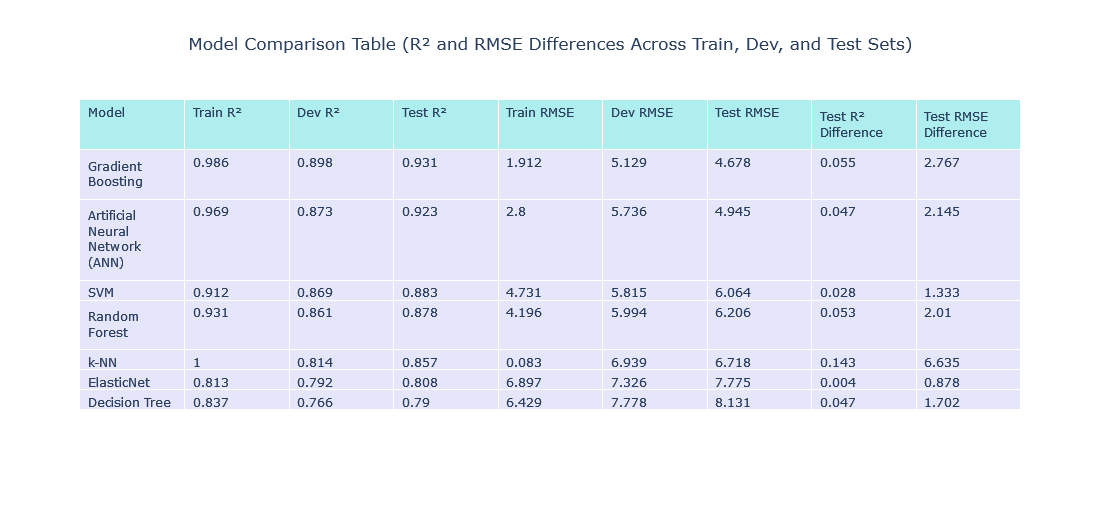

In [12]:
# Adjust the table height based on the number of rows
num_rows = len(results_df)
row_height = 60  # Adjust this value based on your preferences for row height
table_height = row_height * num_rows + 100  # Add some padding for headers and title

# Exclude the Dev differences from the results_df
results_df_filtered = results_df.drop(['Dev R² Difference', 'Dev RMSE Difference'], axis=1)

# Sort the DataFrame by Test R² (descending), Test RMSE (ascending), and Test R² Difference (ascending)
results_df_filtered = results_df_filtered.sort_values(
    by=['Test R²', 'Test RMSE', 'Test R² Difference', 'Test RMSE Difference'],
    ascending=[False, True, True, True]
)

# Display the comparison table using Plotly for a larger and more visually appealing result
fig = go.Figure(data=[go.Table(
    header=dict(values=list(results_df_filtered.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[results_df_filtered[col] for col in results_df_filtered.columns],
               fill_color='lavender',
               align='left'))
])

# Adjust the height to fit all rows
fig.update_layout(
    title_text="Model Comparison Table (R² and RMSE Differences Across Train, Dev, and Test Sets)",
    title_x=0.5,
    height=table_height  # Set the calculated height
)

fig.show()


In this section of the analysis, I iteratively adjusted the hyperparameters for each model to address the problem of overfitting and improve generalization on unseen data. Overfitting occurs when a model performs well on the training set but fails to generalize on validation or test sets, leading to high variance.

### Hyperparameter Tuning Strategy:
For each model, I employed a GridSearchCV approach to explore a range of hyperparameters and select the best combination based on validation performance. Here's how I addressed overfitting for specific models:

- **ElasticNet**: By setting `alpha` to 0.1 and `l1_ratio` to 0.7, I applied a combination of L1 (Lasso) and L2 (Ridge) regularization. This balance penalizes the complexity of the model, reducing overfitting while retaining enough flexibility to capture relationships in the data.
  
- **Decision Tree**: I limited the model's complexity by restricting the `max_depth` to 7, and setting `min_samples_leaf` to 5. These constraints force the model to generalize better by ensuring that each leaf node contains a minimum number of samples, preventing the model from overfitting to the training data.

- **Random Forest**: I kept `max_depth` unlimited, but increased the `min_samples_leaf` to 5 to prevent overfitting. Using 300 trees also ensures that the model captures a wide range of patterns while maintaining stability across different datasets.

- **Gradient Boosting**: To mitigate overfitting, I set a **lower learning rate** of 0.05, and restricted the tree depth to 5 while increasing the `min_samples_leaf` to 10. This slower learning rate helps the model avoid fitting noise in the training data and generalizes better to new data.

- **SVM**: By setting `C` to 10 and `epsilon` to 0.5 with an RBF kernel, I controlled the balance between model flexibility and error tolerance. This prevents the model from overfitting to small deviations in the data.

- **k-NN**: I increased the number of neighbors to 10 and weighted the predictions by distance to smooth the decision boundaries and reduce sensitivity to noise, which helps with overfitting.

- **Artificial Neural Network (ANN)**: I used a smaller learning rate (`learning_rate_init = 0.01`) and a regularization parameter (`alpha = 0.1`) to avoid overfitting while maintaining model flexibility with a hidden layer size of 50 neurons.

### Results:
- **Gradient Boosting** and **Artificial Neural Network (ANN)** showed the best performance. respectively Both models exhibited strong generalization, with low overfitting as indicated by their small R² and RMSE differences.
  
- **Random Forest** and **SVM** also performed well. These models showed moderate overfitting, but the chosen hyperparameters helped maintain good generalization.
  
- **k-NN**, despite achieving high accuracy on the training set, suffered from significant overfitting, as seen in the large R² and RMSE differences between the train and test sets.
  
- **ElasticNet** and **Linear Regression** had lower performance compared to more complex models but generalized well, with minimal overfitting and stable performance across the dev and test sets.

Through these iterative adjustments, I was able to reduce overfitting in most models while maximizing their generalization performance on unseen data.
In addition to the hyperparameter tuning, the models can still be further optimized through other techniques such as error analysis and additional experimentation. By analyzing the types of errors the models make (e.g., large errors for certain feature values or outliers), I can identify areas where improvements are needed. Techniques like cross-validation, feature selection, or even ensembles of models may enhance performance further.
Additionally, investigating the residuals or applying methods like regularization adjustments or feature engineering could reduce remaining overfitting or improve accuracy. Therefore, while the current models show good results, there are still opportunities for further refinement and optimization.

In [9]:
# Separate regression models from other models
regression_models = ['Linear Regression', 'ElasticNet']
other_models = ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'SVM', 'k-NN', 'Artificial Neural Network (ANN)']

if feature_importances:
    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame(feature_importances).T
    importance_df.columns = X.columns
    importance_df = importance_df.melt(var_name='Feature', value_name='Importance', ignore_index=False)
    importance_df.reset_index(inplace=True)
    importance_df.rename(columns={'index': 'Model'}, inplace=True)
    
    # Split the DataFrame into regression and other models
    regression_df = importance_df[importance_df['Model'].isin(regression_models)]
    other_models_df = importance_df[importance_df['Model'].isin(other_models)]
    
    # Plot for Regression Models (Coefficients)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', hue='Model', data=regression_df, palette='Blues')
    plt.title('Feature Coefficients (Importance) for Regression Models')
    plt.show()

    # Plot for Other Models (Feature Importance)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', hue='Model', data=other_models_df, palette='Greens')
    plt.title('Feature Importance for Tree-Based Models, SVM, k-NN, and ANN')
    plt.show()


### Units Explanation:

**Regression Models** (Linear Regression, ElasticNet):
For regression models, the importance of a feature is represented by its coefficient, which directly shows the weight or influence of that feature on the target variable.

**Other Models** (Random Forest, Gradient Boosting, etc.):
In tree-based models or ANN, the importance of a feature is typically based on how much it reduces the error (e.g., reduction in mean squared error) across all the trees or layers. Higher values indicate that a feature is used more frequently and significantly in the model's decision-making process.

In [8]:
# Separate regression models from other models
regression_models = ['Linear Regression', 'ElasticNet']
other_models = ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'SVM', 'k-NN', 'Artificial Neural Network (ANN)']

if feature_importances:
    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame(feature_importances).T
    importance_df.columns = X.columns
    importance_df = importance_df.melt(var_name='Feature', value_name='Importance', ignore_index=False)
    importance_df.reset_index(inplace=True)
    importance_df.rename(columns={'index': 'Model'}, inplace=True)
    
    # Split the DataFrame into regression and other models
    regression_df = importance_df[importance_df['Model'].isin(regression_models)]
    other_models_df = importance_df[importance_df['Model'].isin(other_models)]
    
    # Sort features by importance within each model for regression models
    regression_df = regression_df.sort_values(by=['Model', 'Importance'], ascending=[True, False])

    # Sort features by importance within each model for other models
    other_models_df = other_models_df.sort_values(by=['Model', 'Importance'], ascending=[True, False])
    
    # Plot for Regression Models (Sorted by Coefficients)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', hue='Model', data=regression_df, palette='Blues')
    plt.title('Feature Coefficients (Importance) for Regression Models (Sorted)')
    plt.show()

    # Plot for Other Models (Sorted by Feature Importance)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', hue='Model', data=other_models_df, palette='Greens')
    plt.title('Feature Importance for Tree-Based Models, SVM, k-NN, and ANN (Sorted)')
    plt.show()
